# Preparations

In [1]:
import sys
import math
import copy
import itertools
import numpy as np

import scipy.stats
import scipy.interpolate
from scipy.optimize import curve_fit
from scipy.interpolate import LinearNDInterpolator, CloughTocher2DInterpolator

%matplotlib inline
import matplotlib.colors
import matplotlib.pyplot as plt
import matplotlib.cm as cm
plt.rcParams["figure.figsize"] = (5, 5)
from matplotlib.mlab import griddata

from sklearn.preprocessing import StandardScaler

sys.path.append('..')
from higgs_inference.various.utils import interpolate

# Settings

In [2]:
# Doesn't do anything now except affect filenames
main_mode = 'smearing'

# Interpolation in final plot. If both are False, use a linear interpolator.
interpolation_method = 'linear'

# Which benchmark point to use
use_not_trained_benchmark = True

scatter_alpha=0.5

In [6]:
thetas = np.load('../data/thetas/thetas_parameterized.npy')

n_thetas = len(thetas)
theta1 = 708
theta_observed = 0
thetas_train = list(range(17,1017))
thetas_test = list(range(17))

if use_not_trained_benchmark:
    theta_benchmark = 9
    benchmark_name = 'nottrained'
else:
    theta_benchmark = 422
    benchmark_name = 'trained'
    
pbp_training_thetas = [0, 13, 14, 15, 16, 9, 422, 956, 666, 802, 675, 839, 699, 820, 203, 291, 634, 371, 973, 742, 901, 181, 82, 937, 510, 919, 745, 588, 804, 963, 396, 62, 401, 925, 874, 770, 108, 179, 669, 758, 113, 587, 600, 975, 496, 66, 467, 412, 701, 986, 598, 810, 97, 18, 723, 159, 320, 301, 352, 159, 89, 421, 574, 923, 849, 299, 119, 167, 939, 402, 52, 787, 978, 41, 873, 533, 827, 304, 294, 760, 890, 539, 1000, 291, 740, 276, 679, 167, 125, 429, 149, 430, 720, 123, 908, 256, 777, 809, 269, 851]
basis_thetas = [0, 101, 106, 902, 910,
                226, 373, 583, 747, 841,
                599, 709, 422, 367, 167]
thetas_highlighted = []

print(thetas[theta1])
print(thetas[theta_benchmark])

X_observed = np.load('../data/unweighted_events/smeared_X_test.npy')

[0.39293227 0.43229216]
[-0.5 -0.5]


In [4]:
colors=['C0', 'C1', 'C2', 'C3', 'C4', 'C5']

def lighter_color(color, fraction_white=0.5):
    rgb = np.asarray(matplotlib.colors.to_rgb(color))
    white = np.asarray((1.,1.,1.))
    return fraction_white * white + (1. - fraction_white)*rgb

# Define strategies and load results

In [7]:
labels = []
suffices = []
folders = []

panel_indices = ([], [], [], []) # Usually, use four panels

expected_llr = []
p_values = []
q_medians = []
q_thresholds = []
q_threshold_uncertainties = []

r_benchmark = []
scores_benchmark = []
r_roam = []

def _load(name, folder='parameterized'):
    return np.load('../results/' + folder + '/' + name + '_smeared.npy')

def add_strategy(label, suffix, folder,
                 panel=-1, try_scores=True, is_truth=False):
    
    try:
        _expected_llr = _load('llr_' + suffix, folder)
        _r_benchmark = _load('r_' + benchmark_name + '_' + suffix, folder)
            
    except IOError:
        print('Results for strategy ' + label + ' not found')
        return
    
    try:
        _p_values = _load('p_values_' + suffix, folder)
        do_neyman = True
    except IOError:
        _p_values = None
        do_neyman = False
    
    try:
        _q_thresholds = _load('neyman_qcut_' + suffix, folder)
        _q_threshold_uncertainties = _load('neyman_qcut_uncertainties_' + suffix, folder)
        _q_medians = _load('neyman_qmedian_' + suffix, folder)
    except IOError:
        _q_thresholds = None
        _q_threshold_uncertainties = None
        _q_medians = None
    
    try:
        _r_roam = _load('r_roam_' + suffix, folder)
        do_roaming = True
    except IOError:
        _r_roam = None
        do_roaming = False
    
    if try_scores:
        try:
            _scores_benchmark = _load('scores_' + benchmark_name + '_' + suffix, folder)
            do_scores = True
        except IOError:
            _scores_benchmark = None
            do_scores = False
    else:
        _scores_benchmark = None
        do_scores = False
        
    labels.append(label)
    
    expected_llr.append(_expected_llr)
    p_values.append(_p_values)
    q_medians.append(_q_medians)
    q_threshold_uncertainties.append(_q_threshold_uncertainties)
    q_thresholds.append(_q_thresholds)
    
    r_benchmark.append(_r_benchmark)
    scores_benchmark.append(_scores_benchmark)
    r_roam.append(_r_roam)
    
    index = len(labels) - 1
    if panel >= 0 and panel < 4:
        panel_indices[panel].append(index)
        
    if do_neyman or do_roaming or do_scores or do_densities:
        supported = []
        if do_neyman:
            supported.append('Neyman construction')
        if do_roaming:
            supported.append('x dependence plots')
        if do_scores:
            supported.append('score scatter plots')
        supported = ', '.join(supported)
            
        print('Loaded strategy ' + label + ' with support for ' + supported)
        
    else:
        print('Loaded strategy ' + label)
    

In [8]:
add_strategy('AFC, 2d', 'afc_2d', 'afc', panel=0, try_scores=False)
add_strategy('AFC, 5d', 'afc_5d', 'afc', panel=0, try_scores=False)

#add_strategy('carl, PbP raw', 'carl', 'point_by_point', panel=0, try_scores=False)
#add_strategy('carl, PbP cal.', 'carl_calibrated', 'point_by_point', panel=0, try_scores=False, new_convention_fix=True)

add_strategy('carl, param. raw', 'carl', 'parameterized', panel=0)
add_strategy('carl, param. cal.', 'carl_calibrated', 'parameterized', panel=0, try_scores=False)

add_strategy('carl + score, param. raw', 'combined', 'parameterized', panel=1)
add_strategy('carl + score, param. cal.', 'combined_calibrated', 'parameterized', panel=1, try_scores=False)

add_strategy('SM score regr., score cal.', 'scoreregression_score', 'score_regression', panel=2, try_scores=False)
add_strategy('SM score regr., dynamic score cal.', 'scoreregression_rotatedscore', 'score_regression', panel=2, try_scores=False)
add_strategy('SM score regr., score.theta cal.', 'scoreregression_scoretheta', 'score_regression', panel=2, try_scores=False)

#add_strategy('regression, PbP raw', 'regression', 'point_by_point', panel=3, try_scores=False)
add_strategy('ratio regr., param. raw', 'regression', 'parameterized', panel=3)
add_strategy('ratio regr. + score, param. raw', 'combinedregression', 'parameterized', panel=3)


Results for strategy AFC, 2d not found
Results for strategy AFC, 5d not found
Loaded strategy carl, param. raw with support for x dependence plots, score scatter plots
Loaded strategy carl, param. cal. with support for x dependence plots
Loaded strategy carl + score, param. raw with support for x dependence plots, score scatter plots
Loaded strategy carl + score, param. cal. with support for x dependence plots
Results for strategy SM score regr., score cal. not found
Results for strategy SM score regr., dynamic score cal. not found
Results for strategy SM score regr., score.theta cal. not found
Loaded strategy ratio regr., param. raw with support for x dependence plots, score scatter plots
Results for strategy ratio regr. + score, param. raw not found


# Interpolate LLR and p values

In [9]:
# grid
thetas_filtered = thetas[:]
xi = np.linspace(-1.0, 1.0, 200)
yi = np.linspace(-1.0, 1.0, 200)
xx, yy = np.meshgrid(xi, yi)

# interpolate
interpolated_p_values = []
interpolated_expected_llr = []
interpolated_expected_llr_mle = []

for p_vals, llr in zip(p_values, expected_llr):
    
    _llr, _mle = interpolate(thetas, llr, xx, yy, method=interpolation_method, subtract_min=True)
    if p_vals is not None:
        _p_vals, _ = interpolate(thetas, np.log(np.clip(p_vals,1.e-6, 1.)), xx, yy, method=interpolation_method)
        _p_vals = np.exp(_p_vals)
    else:
        _p_vals = None
    
    interpolated_p_values.append(_p_vals)
    interpolated_expected_llr.append(_llr)
    interpolated_expected_llr_mle.append(_mle)

In [10]:
# interpolate
interpolated_q_medians = []
interpolated_q_thresholds = []
interpolated_95cl_excluded = []

for qmed, qthresh, qthresh_err in zip(q_medians, q_thresholds, q_threshold_uncertainties):
    
    if qmed is None or qthresh is None or qthresh_err is None:
        interpolated_q_medians.append(None)
        interpolated_q_thresholds.append(None)
        interpolated_95cl_excluded.append(None)
        continue
    
    try:
        _qmed, _ = interpolate(thetas, qmed, xx, yy, method=interpolation_method)
        _qthresh, _ = interpolate(thetas, qthresh, xx, yy, z_uncertainties_thetas=qthresh_err,
                           method=interpolation_method)
        
        _excluded = _qmed - _qthresh
    
        interpolated_q_medians.append(_qmed)
        interpolated_q_thresholds.append(_qthresh)
        interpolated_95cl_excluded.append(_excluded)
    
    except ValueError as err:
        print(err)
        interpolated_q_medians.append(None)
        interpolated_q_thresholds.append(None)
        interpolated_95cl_excluded.append(None)

# Likelihood ratio histograms

No handles with labels found to put in legend.


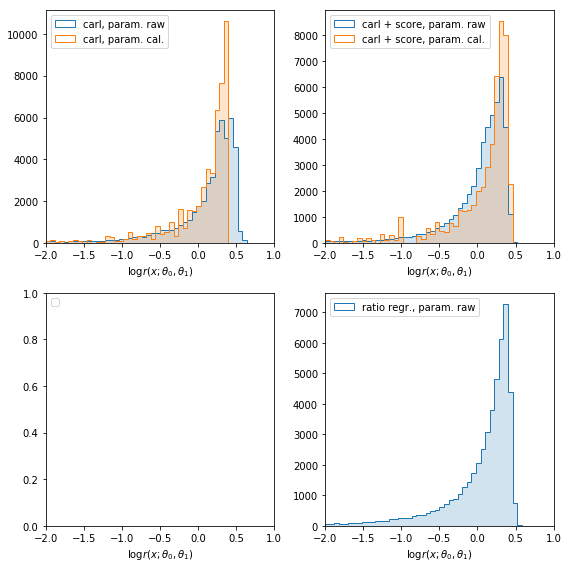

In [13]:
this_range = (-2.,1.)
this_bins  = 50

fig = plt.figure(figsize=(8.,8.))

for panel in range(4):
    
    ax = plt.subplot(2,2,panel+1)
    
    for i, s in enumerate(panel_indices[panel]):
        plt.hist(np.log(r_benchmark[s]), range=this_range, bins=this_bins, color=colors[i], alpha=0.2)
    
    for i, s in enumerate(panel_indices[panel]):
        plt.hist(np.log(r_benchmark[s]), range=this_range, bins=this_bins, color=colors[i], histtype='step',
                 label=labels[s])
    
    plt.legend(loc='upper left')
    
    plt.xlabel(r'$\log r(x; \theta_0, \theta_1)$')
    plt.xlim(this_range[0],this_range[1])

plt.tight_layout()
plt.savefig("../figures/results_smearing/r_histograms_" + main_mode + ".pdf")

# Theta dependence

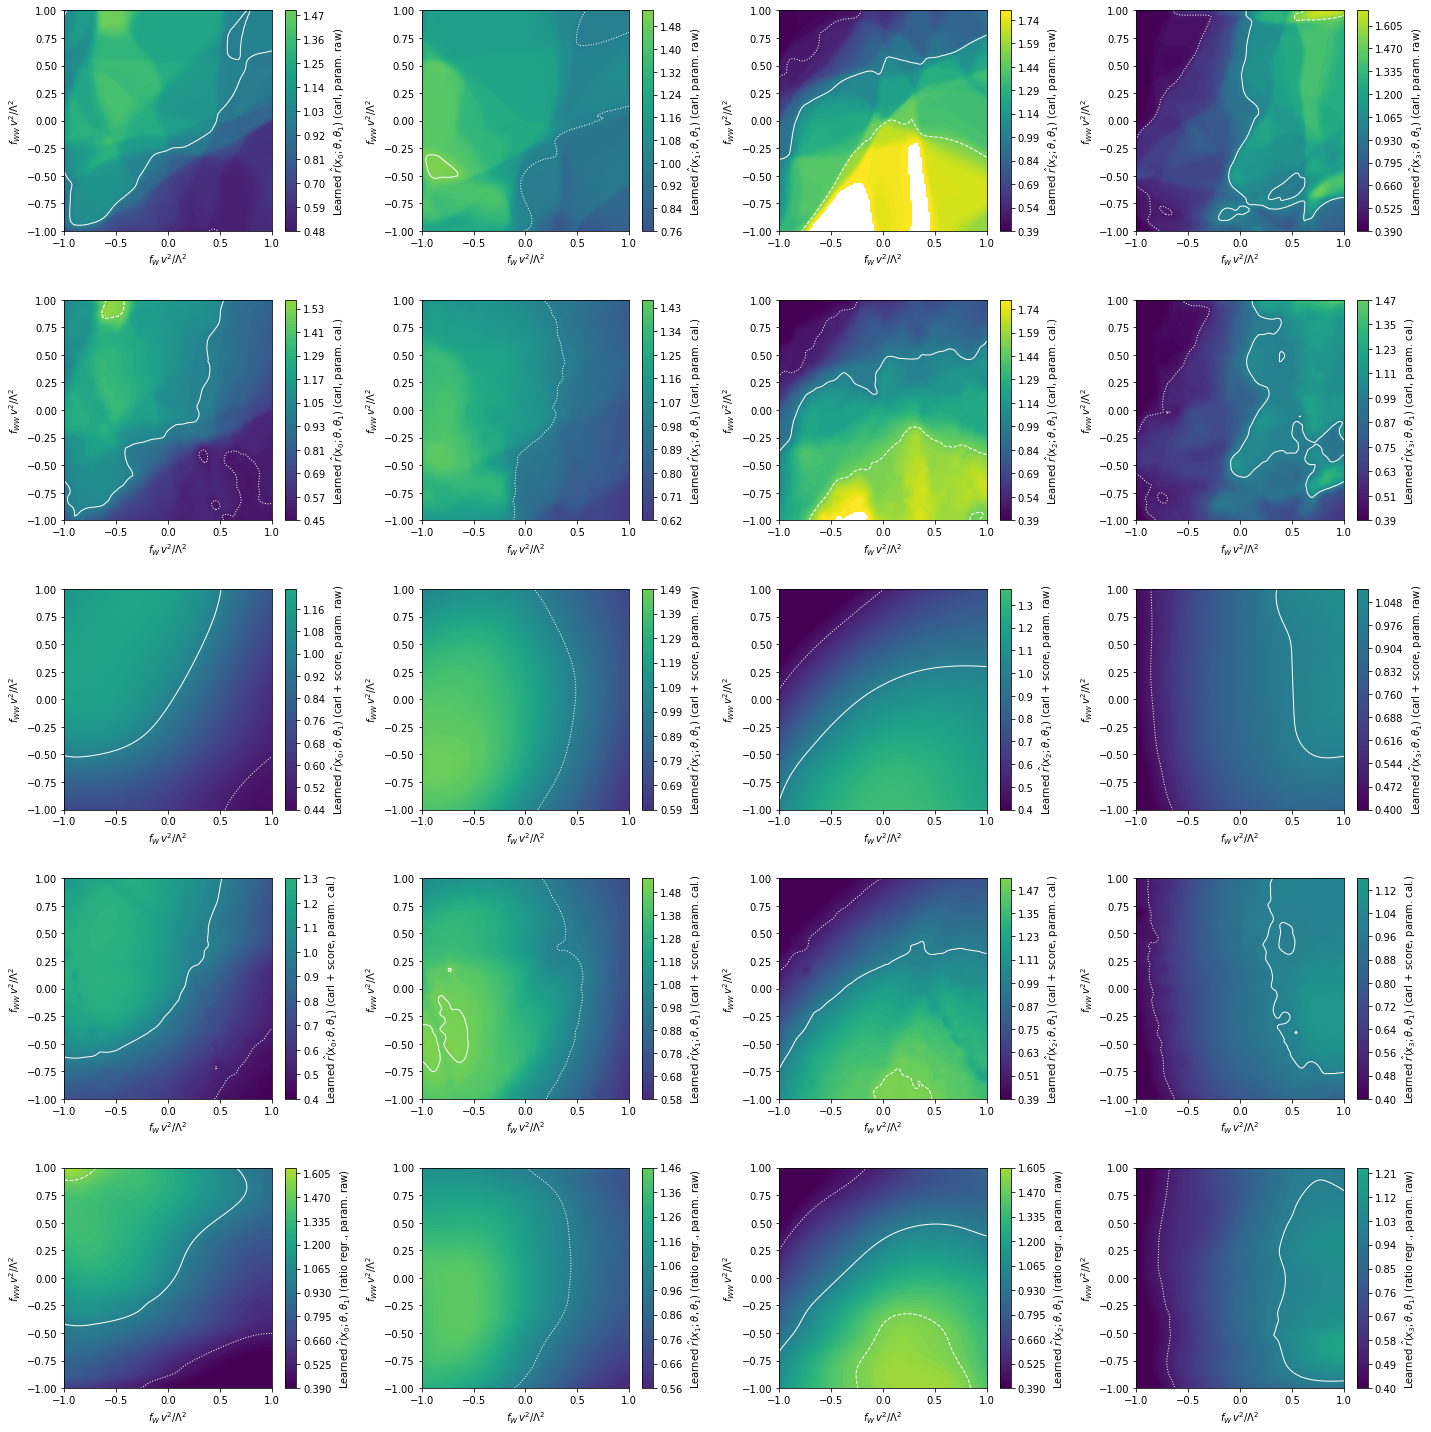

In [14]:
rmin, rmax = 0.4, 1.8
r_lines = [0.5,1.,1.5]

n_roaming = 10
show_roaming = [1,6,7,11]
n_roaming_show = len(show_roaming)

n_thetas_roam = 101
xi = np.linspace(-1.0, 1.0, n_thetas_roam)
yi = np.linspace(-1.0, 1.0, n_thetas_roam)

n_strategies_shown = sum([r is not None for r in r_roam])

fig = plt.figure(figsize=(5*n_roaming_show, 4*n_strategies_shown))

i = 0
for r, l in zip(r_roam, labels):
    
    if r is None:
        continue
        
    for j in range(n_roaming_show):
        ax = plt.subplot(n_strategies_shown, n_roaming_show, 1 + n_roaming_show*i + j)
        
        zi = np.clip(r[show_roaming[j]].reshape((n_thetas_roam, n_thetas_roam)), rmin, rmax)

        cs = plt.contourf(xi, yi, zi,
                          100, cmap="viridis", vmin=rmin, vmax=rmax)
        cbar = plt.colorbar()
        plt.contour(xi, yi, zi,
                    r_lines,
                    linewidths=1., colors='white',
                    linestyles=['dotted','solid','dashed'])

        #plt.scatter(thetas[thetas_train,0], thetas[thetas_train,1],
        #            marker='o', c='w', alpha=0.5,  s=5., lw=0, zorder=8)
        #plt.scatter([thetas[theta1, 0]], [thetas[theta1, 1]],
        #            marker='o', c='w', s=50, lw=0, zorder=9)

        plt.xlim(-1.0, 1.0)
        plt.ylim(-1.0, 1.0)
        plt.xlabel(r"$f_{W} \, v^2 / \Lambda^2$")
        plt.ylabel(r"$f_{WW} \, v^2 / \Lambda^2$")
        cbar.set_label(r'Learned $\hat{r}(x_' + str(j) + r'; \theta, \theta_1)$ (' + l + ')')
        
    i += 1

plt.tight_layout()
plt.savefig("../figures/results_smearing/theta_dependence_comparison_" + main_mode + ".pdf")

# Benchmark theta: x dependence

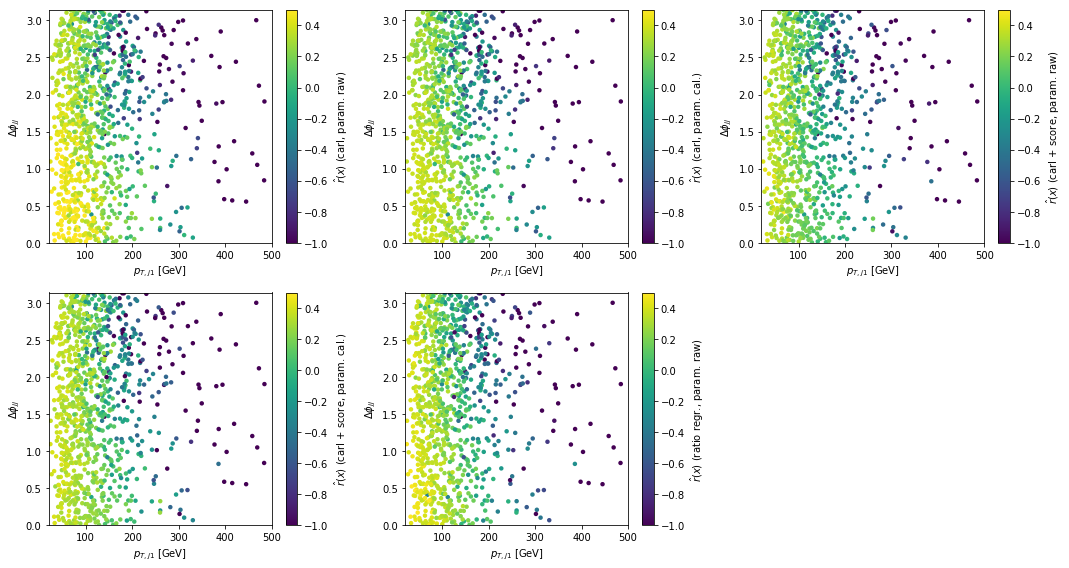

In [16]:
skip = 50

n_columns = math.ceil(len(r_benchmark) / 3.)

fig = plt.figure(figsize=(15.,4. * n_columns))

for i, (r, l) in enumerate(zip(r_benchmark, labels)):
    
    ax = plt.subplot(n_columns, 3, i + 1)

    plt.scatter(X_observed[::skip,1],
                X_observed[::skip,41],
                c=np.log(r[::skip]),
                vmin=-1., vmax=0.5,
                marker='o', s=20., lw=0.)
    cbar = plt.colorbar()
    
    plt.xlim(20.,500.)
    plt.ylim(0.,math.pi)
    plt.xlabel(r'$p_{T,j1}$ [GeV]')
    plt.ylabel(r'$\Delta \phi_{jj}$')
    cbar.set_label(r'$\hat{r}(x)$ (' + l + ')')

plt.tight_layout()
plt.savefig('../figures/results_smearing/x_dependence_' + main_mode + '.pdf')

# Expected LLR contours

No handles with labels found to put in legend.


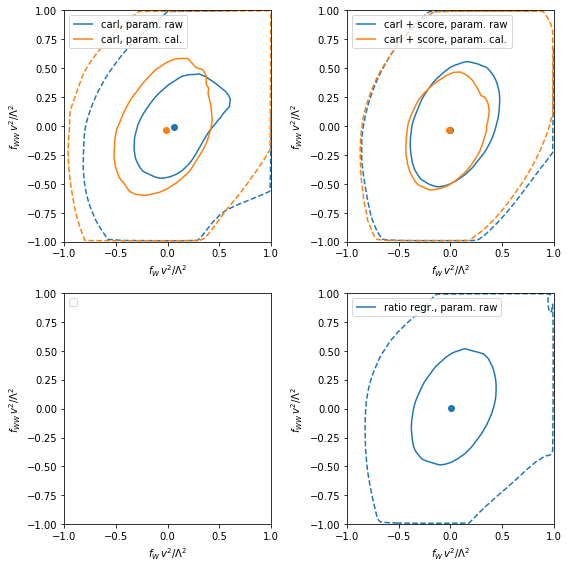

In [18]:
# grid
thetas_filtered = thetas[:]
xi = np.linspace(-1.0, 1.0, 200)
yi = np.linspace(-1.0, 1.0, 200)
xx, yy = np.meshgrid(xi, yi)

llr_lines = [4.,16.]

fig = plt.figure(figsize=(8.,8.))

for panel in range(4):
    
    ax = plt.subplot(2, 2, panel+1)
        
    for i, s in enumerate(panel_indices[panel]):
        cs = plt.contour(xi, yi, interpolated_expected_llr[s], llr_lines,
                         linewidths=1.5, colors=colors[i],
                         linestyles=['solid','dashed'])
        cs.collections[0].set_label(labels[s])
        
    for i, s in enumerate(panel_indices[panel]):
        plt.scatter([xi[interpolated_expected_llr_mle[s][1]]],
                    [yi[interpolated_expected_llr_mle[s][0]]],
                    marker='o', c=colors[i], s=50, lw=0, zorder=10)

    plt.legend(loc='upper left')

    plt.xlim(-1.0, 1.0)
    plt.ylim(-1.0, 1.0)
    plt.xlabel(r"$f_{W} \, v^2 / \Lambda^2$")
    plt.ylabel(r"$f_{WW} \, v^2 / \Lambda^2$")

plt.tight_layout()
plt.savefig("../figures/results_smearing/likelihood_contours_" + main_mode + ".pdf")

# Individual LLR outputs for debugging

ratio regr., param. raw


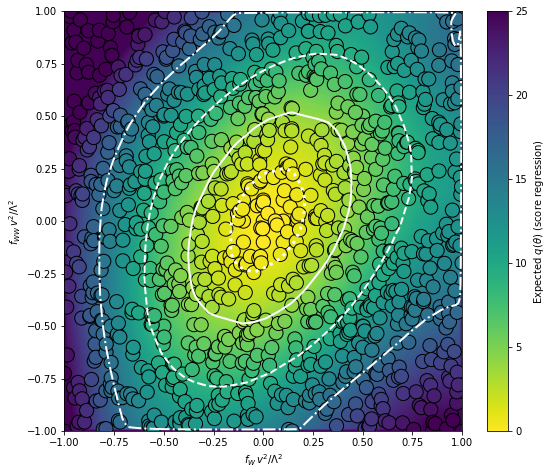

In [19]:
i = 4
print(labels[i])

plt.figure(figsize=(8.,6.7))

zi = np.clip(interpolated_expected_llr[i],0.,25.)

cs = plt.contourf(xi, yi, zi, 100, vmin=0.,vmax=25., cmap='viridis_r')

cs = plt.contour(xi, yi, zi, [1,4,9,16],
                 linewidths=[3.,2.,2.,2.], colors='w',
                 linestyles=['dotted', 'solid', 'dashed', '-.'])
cs.collections[0].set_label(r'$E[q(\theta)] = 1^2$')
cs.collections[1].set_label(r'$E[q(\theta)] = 2^2$')
cs.collections[2].set_label(r'$E[q(\theta)] = 3^2$')
cs.collections[3].set_label(r'$E[q(\theta)] = 4^2$')

plt.scatter(thetas[:,0], thetas[:,1],
            c=expected_llr[i] - min(expected_llr[i][:]),
            s=200., lw=1., cmap='viridis_r', edgecolors='k',
            vmin=0., vmax=25.)
cbar = plt.colorbar()

plt.xlim(-1.,1.)
plt.ylim(-1.,1.)

plt.xlabel(r"$f_{W} \, v^2 / \Lambda^2$")
plt.ylabel(r"$f_{WW} \, v^2 / \Lambda^2$")
cbar.set_label(r'Expected $q(\theta)$ (score regression)')

plt.tight_layout()
plt.savefig("../figures/results_smearing/likelihood_contour_regression.pdf")

# CL contours from Neyman construction

/Users/johannbrehmer/anaconda3/envs/higgs_inference/lib/python3.6/site-packages/matplotlib/contour.py:1180: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


TypeError: Input z must be a 2D array.

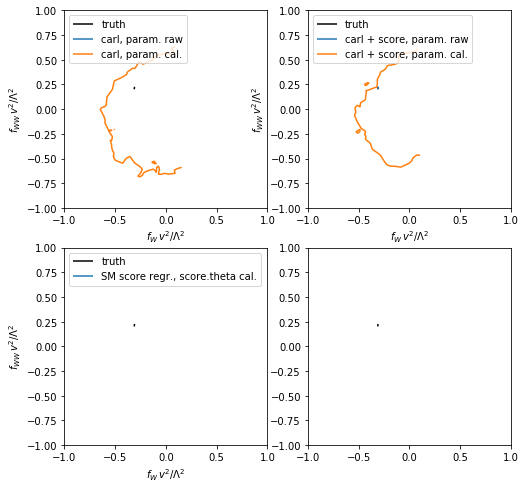

In [22]:
cl_lines = [0.001,0.05,0.3]

fig = plt.figure(figsize=(8.,8.))

for panel in range(4):
    
    ax = plt.subplot(2, 2, panel+1)

    cs = plt.contour(xi, yi, interpolated_95cl_excluded[truth_index], [0.],
                     linewidths=1.5, colors='black',
                     linestyles='solid')
    cs.collections[0].set_label(labels[truth_index])
        
    i = 0
    for s in panel_indices[panel]:
        if interpolated_p_values[s] is None:
            continue
        
        cs = plt.contour(xi, yi, interpolated_95cl_excluded[s], [0.],
                         linewidths=1.5, colors=colors[i],
                         linestyles='solid')
        cs.collections[0].set_label(labels[s])
        
        i += 1

    plt.legend(loc='upper left')

    plt.xlim(-1.0, 1.0)
    plt.ylim(-1.0, 1.0)
    plt.xlabel(r"$f_{W} \, v^2 / \Lambda^2$")
    plt.ylabel(r"$f_{WW} \, v^2 / \Lambda^2$")

plt.tight_layout()
plt.savefig("../figures/results/cl_contours_" + main_mode + ".pdf")

# Individual p-value plots for debugging

In [ ]:
zmin, zmax = 0.,0.5

plt.figure(figsize=(8,6.5))

cs = plt.contourf(xi, yi, interpolated_p_values[truth_index], 100, cmap='viridis',
                 vmin=zmin, vmax=zmax)
#plt.colorbar(cs)

cs = plt.contour(xi, yi, interpolated_p_values[truth_index], [0.05],
                 linewidths=1.5, colors='w',
                 linestyles='solid')
cs.collections[0].set_label('Expected $95 \%$ CL contour')

plt.scatter(thetas[:,0], thetas[:,1],
            c=p_values[truth_index],
            s=200., lw=1., cmap='viridis', edgecolors='k',
            vmin=zmin, vmax=zmax)
cbar = plt.colorbar()

plt.legend(loc='lower right')

plt.xlim(-1.,1.)
plt.ylim(-1.,1.)
plt.xlabel(r"$f_{W} \, v^2 / \Lambda^2$")
plt.ylabel(r"$f_{WW} \, v^2 / \Lambda^2$")
cbar.set_label('Median $p$-value (truth)')

plt.tight_layout()
plt.savefig("../figures/results/cl_contour_truth.pdf")

In [ ]:
i=4
print(labels[i])
zmin, zmax = 0.,0.5

plt.figure(figsize=(8,6.5))

cs = plt.contourf(xi, yi, interpolated_p_values[i], 100, cmap='viridis',
                 vmin=zmin, vmax=zmax)
#plt.colorbar(cs)

cs = plt.contour(xi, yi, interpolated_p_values[i], [0.05],
                 linewidths=1.5, colors='w',
                 linestyles=['solid'])
cs.collections[0].set_label('Expected $95 \%$ CL contour')

plt.scatter(thetas[:,0], thetas[:,1],
            c=p_values[i],
            s=200., lw=1., cmap='viridis', edgecolors='k',
            vmin=zmin, vmax=zmax)
cbar = plt.colorbar()

plt.legend(loc='lower right')

plt.xlim(-1.,1.)
plt.ylim(-1.,1.)
plt.xlabel(r"$f_{W} \, v^2 / \Lambda^2$")
plt.ylabel(r"$f_{WW} \, v^2 / \Lambda^2$")
cbar.set_label('Median $p$-value (truth)')

plt.tight_layout()
plt.savefig("../figures/results/cl_contour_combined.pdf")